In [111]:
import numpy as np
import xgboost as xgb
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from xgboost import plot_importance


public_data = pd.read_csv('extracted_public_data.csv')
public_data = public_data.dropna()
mapping = {
    "precision": {"single": 0, "double": 1},
    "backend": {"GPU": 0, "CPU": 1}
}
remapped_public_data = public_data.replace(mapping) 
remapped_public_data['normalized_threshold'] = (1/8) * np.log2(remapped_public_data['threshold'])

features = pd.read_csv('qasm_features_scaled.csv')
embeddings = pd.read_csv('generated_embeddings.csv')
if 'Unnamed: 0' in embeddings.columns:
    embeddings = embeddings.drop(columns=['Unnamed: 0'])

match_col_test = remapped_public_data.columns[0]
match_col_features = features.columns[0]

inputs = pd.merge(
    remapped_public_data, 
    features, 
    left_on=match_col_test, 
    right_on=match_col_features, 
    how='left'
)
inputs = pd.merge(
    inputs, 
    embeddings, 
    left_on='circuit', 
    right_on='name', 
    how='inner'
)

inputs.to_csv('inputs.csv', index=False)


y = np.log10(public_data['expected_runtime_sec'])
y.to_csv('runtimes.csv', index=False)
inputs = inputs.drop(columns=['circuit', "threshold", 'fidelity', 'expected_runtime_sec', 'name_x', 'name_y'])




C:\Users\percy\AppData\Local\Temp\ipykernel_9344\1624228006.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  remapped_public_data = public_data.replace(mapping)


In [112]:
X=inputs
Y=y
y.to_csv('y.csv', index=False)

c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:35:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  self.starting_round = model.num_boosted_rounds()


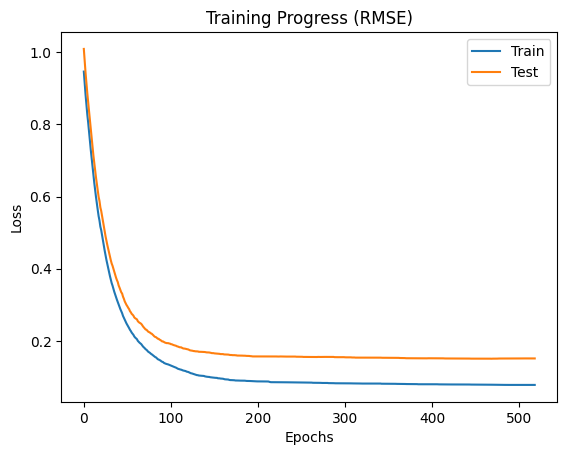

Fold 1 RMSE: 0.02265701512555327


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:35:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  self.starting_round = model.num_boosted_rounds()


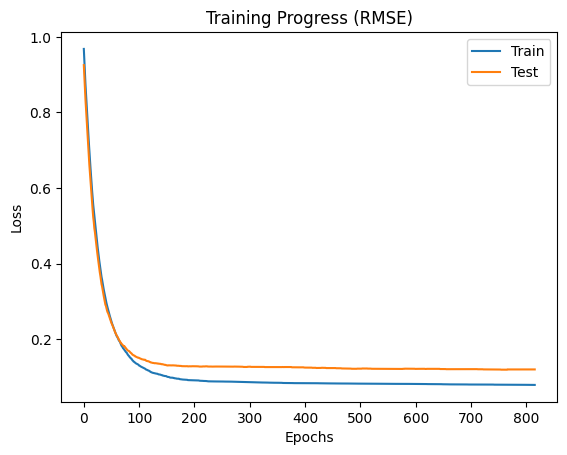

Fold 2 RMSE: 0.014403665970137019


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:35:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  self.starting_round = model.num_boosted_rounds()


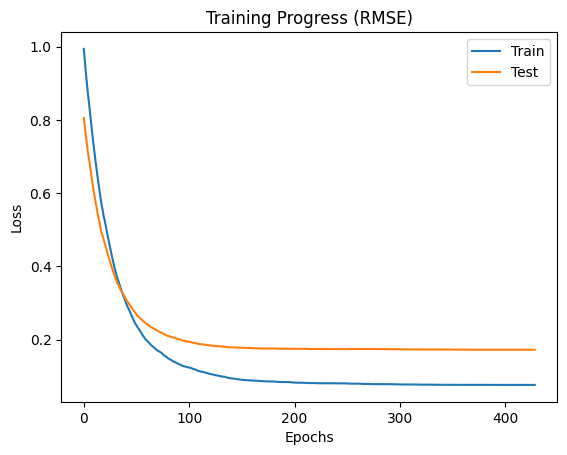

Fold 3 RMSE: 0.029642283690531682


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  self.starting_round = model.num_boosted_rounds()


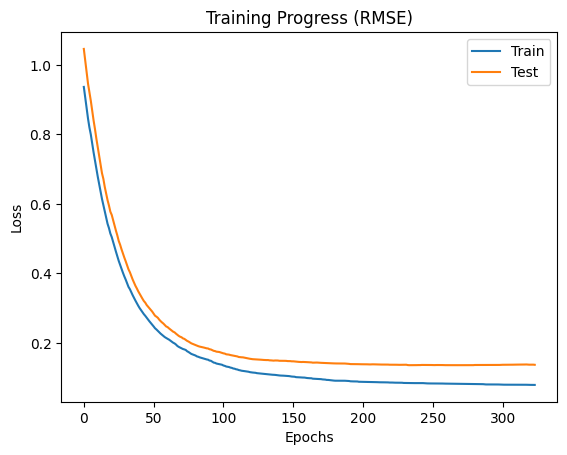

Fold 4 RMSE: 0.018388301869785528


c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\callback.py:386: UserWarning: [11:35:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  self.starting_round = model.num_boosted_rounds()


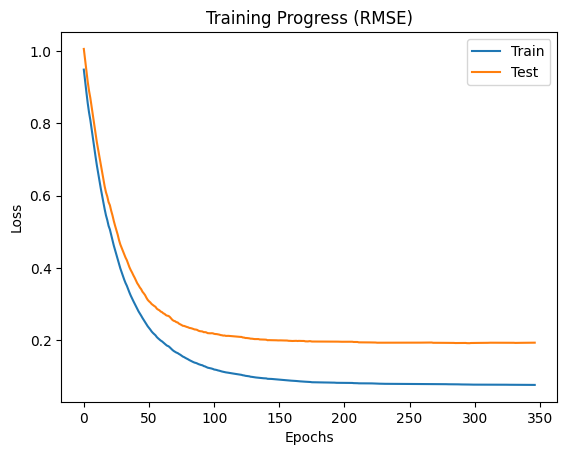

Fold 5 RMSE: 0.036814591993720835
CV RMSE: 0.024381171729945667


In [113]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
preds = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train = X.iloc[train_idx]
    X_val   = X.iloc[val_idx]

    y_train = y.iloc[train_idx]
    y_val   = y.iloc[val_idx]

    eval_set = [(X_train, y_train), (X_val, y_val)]

    model = xgb.XGBRegressor(
        
        
        n_estimators=3000,          # High limit, but use early stopping
        max_depth=4,                # Reduced from 7
        min_child_weight=2,        # Increased from 1.5
        gamma=0.015148663160556427,                  # Increased from 0.2
        rate_drop=0.3665414874182634,              # Increased from 0.1
        skip_drop=0.3410554872883431,
        learning_rate=0.03821282278824164,
        subsample=0.7784344006861772,
        colsample_bytree=0.8998057403862029,       # Reduced from 0.91
        reg_alpha=0.016935465021023638,              # Increased from 0.32
        reg_lambda=0.07053319610596764,             # Increased from 0.08
        early_stopping_rounds=50,   # Added to prevent over-training
        eval_metric="rmse",
        objective="reg:squarederror", # Updated from deprecated reg:linear
        random_state=42
     
    
    
        #n_estimators=1992,
        #max_depth=7,
        #boost= 'dart',
        #min_child_weight=1.5,
        #gamma=0.2,
        #rate_drop=0.1,
        #skip_drop=0.5,
        #learning_rate=0.022920102631846767,
        #subsample=0.6045202444830257,
        #colsample_bytree=0.91678701035139,
        #reg_alpha=0.3272952913628665,
        #reg_lambda=0.08215114108588457,
        #random_state=42,
        #eval_metric=["rmse"], 
        #objective="reg:linear"
    )

    model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False
    )

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds)
    rmse_scores.append(rmse)
    #plot_importance(model, importance_type='gain')
    #plt.show()
    results = model.evals_result()

    plt.plot(results['validation_0']['rmse'], label='Train')
    plt.plot(results['validation_1']['rmse'], label='Test')
    plt.title('Training Progress (RMSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"Fold {fold+1} RMSE:", rmse)
    model.save_model(f"runtime_model_fold_{fold}.json")

print("CV RMSE:", np.mean(rmse_scores))

In [115]:
X_val=[1,1,0.0,1.5269040260551447,0.9071815321518504,1.9096574544725085,0.7084441833433067,1.0000000000000002,0.2208856446090305,0.39199454,0.26013893,0.4084736,-0.6653489,0.14956285,0.3912969,-0.17549169,-0.37322402,-0.4242923,0.20028462,-0.5155624,-0.24035102,0.55093366,-0.4792543,0.4102454,-0.26168942,0.3010856,0.17258094,-0.12163558,0.20772949,0.4228417,-0.6359492,-0.40989298,-0.18708691,0.20276077,0.5209452,0.3531481,0.53207386,0.021295633,1.1220025,0.8461781,1.1374869,-0.08362439,-0.21006688,0.10219448,-0.12782626,0.13302004,-0.20444348,-0.34380102,-0.16987023,-0.33265772,-0.5997433,-0.7051245,-1.2632599,-0.71532977,0.13214707,-0.934882,2.9886205,-1.8037173,-0.5060883
]
X_val = np.array(X_val).reshape(1, -1)

pred = model.predict(X_val)
print(10**pred)

[12.970903]


In [87]:
import optuna
def objective(trial):
    params = {
        "n_estimators": 3000,           # High limit; early stopping will handle the rest
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 15),
        "gamma": trial.suggest_float("gamma", 0.01, 2.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, log=True),
        "rate_drop": trial.suggest_float("rate_drop", 0.1, 0.4),
        "skip_drop": trial.suggest_float("skip_drop", 0.3, 0.7),
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "early_stopping_rounds": 50,
        "random_state": 42
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X):
        model = xgb.XGBRegressor(**params)
        model.fit(
            X.iloc[train_idx],
            y.iloc[train_idx],
            eval_set=[(X.iloc[val_idx], y.iloc[val_idx])],
            verbose=False
        )

        preds = model.predict(X.iloc[val_idx])
        rmse = mean_squared_error(y.iloc[val_idx], preds)
        rmses.append(rmse)

    return np.mean(rmses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)


[I 2026-02-01 08:41:24,469] A new study created in memory with name: no-name-8ce965c8-7c38-43b9-8d2a-f27cf5213149
[W 2026-02-01 08:41:24,473] Trial 0 failed with parameters: {'max_depth': 3, 'learning_rate': 0.03174068395875078, 'min_child_weight': 14, 'gamma': 0.1279008823592544, 'subsample': 0.7919733168310552, 'colsample_bytree': 0.72752451938306, 'reg_alpha': 0.11273472350529858, 'reg_lambda': 0.19780815508807958, 'rate_drop': 0.27295953333876855, 'skip_drop': 0.4862659418011591} because of the following error: ValueError('DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:name: object').
Traceback (most recent call last):
  File "c:\Users\percy\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py", line 407, in pandas_feature_info
    new_feature_types.append(_pandas_dtype_mapper[dtype.name])
                           

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:name: object